In this notebook I load and prepare customer data, engineer time-based features, and split into train, validation, and test sets. I implement the X-learner by hand, training separate models on treatment and control groups, computing pseudo-outcomes, and fitting regressors, without relying on any uplift libraries. I additionally evaluate the X-learner using Uplift@k, Qini curves, and AUUC. Finally, I compare this approach to other models using existing libraries to identify which method ranks customers best by true treatment effect.

In [1]:
import sys
!{sys.executable} -m pip install -q catboost causalml scikit-uplift

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 106.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 3.7 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, CatBoostRegressor
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklift.metrics import qini_auc_score, qini_curve, uplift_auc_score
from causalml.inference.meta import BaseSClassifier, BaseTClassifier
from sklift.models import TwoModels

import warnings
warnings.filterwarnings('ignore')

### Data loading and preprocessing

In [4]:
df_clients = pd.read_csv('/content/drive/MyDrive/ML/projects/uplift/fetch_x5_clients.csv')
df_train = pd.read_csv('/content/drive/MyDrive/ML/projects/uplift/fetch_x5_train.csv')

In [5]:
df_train.head()

,client_id,treatment_flg,target
0,000012768d,0,1
1,000036f903,1,1
2,00010925a5,1,1
3,0001f552b0,1,1
4,00020e7b18,1,1


In [6]:
df_clients.head()

,client_id,first_issue_date,first_redeem_date,age,gender
0,000012768d,2017-08-05 15:40:48,2018-01-04 19:30:07,45,U
1,000036f903,2017-04-10 13:54:23,2017-04-23 12:37:56,72,F
2,000048b7a6,2018-12-15 13:33:11,NaN,68,F
3,000073194a,2017-05-23 12:56:14,2017-11-24 11:18:01,60,F
4,00007c7133,2017-05-22 16:17:08,2018-12-31 17:17:33,67,U


In [7]:
# Keep only the clients in df_clients that appear in the training set,
# since only those have the target values needed to compute uplift metrics

df_clients = df_clients[df_clients['client_id'].isin(df_train['client_id'])].reset_index(drop=True)
print(df_clients.shape, df_train.shape)
print(f"Unique clients: {df_clients['client_id'].nunique()}")

(200039, 5) (200039, 3)
Unique clients: 200039


In [8]:
df_train.isna().sum()

,0
client_id,0
treatment_flg,0
target,0


In [9]:
df_clients.isna().sum()

,0
client_id,0
first_issue_date,0
first_redeem_date,17546
age,0
gender,0


In [10]:
# Show the distribution of the target and treatment variables
# We can see that the treatment and control groups are roughly the same size

print(f"Dataset target mean: {df_train.target.mean()}")
print(f"Dataset treatment mean: {df_train.treatment_flg.mean()}")

Dataset target mean: 0.6198891216212838
Dataset treatment mean: 0.4998075375301816


In [11]:
# Encode gender as integer labels

df_clients['gender'].unique()

gender_dict = {'U': 0, 'F': 1, 'M': 2}

df_clients['gender_encoded'] = df_clients['gender'].map(gender_dict)

In [12]:
df_clients

,client_id,first_issue_date,first_redeem_date,age,gender,gender_encoded
0,000012768d,2017-08-05 15:40:48,2018-01-04 19:30:07,45,U,0
1,000036f903,2017-04-10 13:54:23,2017-04-23 12:37:56,72,F,1
2,00010925a5,2018-07-24 16:21:29,2018-09-14 16:12:49,83,U,0
3,0001f552b0,2017-06-30 19:20:38,2018-08-28 12:59:45,33,F,1
4,00020e7b18,2017-11-27 11:41:45,2018-01-10 17:50:05,73,U,0
...,...,...,...,...,...,...
200034,fffe0abb97,2017-11-27 08:56:54,2018-02-11 09:26:08,35,F,1
200035,fffe0ed719,2017-09-15 08:53:24,2017-12-12 14:50:12,69,U,0
200036,fffea1204c,2018-01-31 16:59:37,2018-03-12 17:02:27,73,F,1
200037,fffeca6d22,2017-12-28 11:56:13,NaN,77,F,1


In [13]:
# Feature engineering
df_features = df_clients.copy()
df_features['first_issue_time'] = (pd.to_datetime(df_features['first_issue_date'])- pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')
df_features['first_redeem_time'] = (pd.to_datetime(df_features['first_redeem_date']) - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')
df_features['issue_redeem_delay'] = df_features['first_redeem_time'] - df_features['first_issue_time']
df_features = df_features.drop(['first_issue_date', 'first_redeem_date'], axis=1)

In [14]:
# The resulting features may contain NaN values but Catboost will handle them as is

df_features.isna().sum()

,0
client_id,0
age,0
gender,0
gender_encoded,0
first_issue_time,0
first_redeem_time,17546
issue_redeem_delay,17546


### Helper functions

In [15]:
# Uplift@k metric
def uplift_at_k(uplift_scores, y_true, treatment, k):
    n_top = int(len(uplift_scores) * k)
    indices = np.argsort(-uplift_scores)[:n_top]
    treat_top = treatment.iloc[indices]
    y_top = y_true.iloc[indices]
    return y_top[treat_top == 1].mean() - y_top[treat_top == 0].mean()

# Uplift distribution
def plot_uplift_distribution(uplift_train, uplift_test, bins=30):
    plt.hist(uplift_train, bins=bins, alpha=0.5, label='Uplift Train', color='blue', edgecolor='black')
    plt.hist(uplift_test, bins=bins, alpha=0.5, label='Uplift Test', color='orange', edgecolor='black')
    plt.title("Distribution of Uplift Scores")
    plt.xlabel("Uplift Score")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

The function below creates a percentile-based uplift plot. The data are sorted by their predicted uplift scores and then split into *n_bins* percentile groups. For each percentile, we calculate the difference in the average target value, *y*, between the treatment and control groups. This difference is the uplift for that bin. The X axis shows the percentiles and the Y axis shows the corresponding uplift values.

In [16]:
def plot_uplift_by_percentile(uplift, y_true, treatment, n_bins=10, title="Uplift by Percentile"):
    """
    Plot uplift by percentiles, including the mean target values
    for the treatment and control groups.

    Parameters:
    - uplift: array of uplift estimates.
    - y_true: true target values.
    - treatment: binary indicator of the treatment group (1 = treated, 0 = control).
    - n_bins: number of percentile bins.
    - title: title of the plot.

    Returns:
    - results_df: a pandas DataFrame containing the uplift analysis results.
    """
    data = pd.DataFrame({'uplift': uplift, 'y': y_true, 'treatment': treatment})
    data = data.sort_values('uplift', ascending=False).reset_index(drop=True)

    bin_size = len(data) // n_bins
    results = []

    for i in range(n_bins):
        start = i * bin_size
        end = (i + 1) * bin_size if i < n_bins - 1 else len(data)
        bin_data = data.iloc[start:end]

        treat_mean = bin_data.loc[bin_data['treatment'] == 1, 'y'].mean()
        control_mean = bin_data.loc[bin_data['treatment'] == 0, 'y'].mean()
        uplift_value = treat_mean - control_mean
        n_treatment = bin_data.loc[bin_data['treatment'] == 1].shape[0]
        n_control = bin_data.loc[bin_data['treatment'] == 0].shape[0]

        results.append({
            'percentile': i + 1,
            'uplift': uplift_value,
            'treat_mean': treat_mean,
            'control_mean': control_mean,
            'n_treatment': n_treatment,
            'n_control': n_control
        })

    results_df = pd.DataFrame(results)

    plt.plot(results_df['percentile'], results_df['uplift'], marker='o', linestyle='-', label='Uplift')
    plt.plot(results_df['percentile'], results_df['treat_mean'], marker='o', linestyle='--', label='Treatment Mean')
    plt.plot(results_df['percentile'], results_df['control_mean'], marker='o', linestyle='--', label='Control Mean')
    plt.title(title)
    plt.xlabel("Percentile")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(range(1, n_bins + 1))
    plt.show()

    return results_df

### Split the data

In [17]:
# Merge two datasets for convenience

df = pd.merge(df_features,
              df_train,
              on='client_id',
              how='left'
              )

In [18]:
train, test = train_test_split(df, test_size=0.2, random_state=77)
train, val = train_test_split(train, test_size=0.2, random_state=89)

In [19]:
print(f"Train samples: {train.shape[0]}")
print(f"Val samples: {val.shape[0]}")
print(f"Test samples: {test.shape[0]}")

Train samples: 128024
Val samples: 32007
Test samples: 40008


In [20]:
df

,client_id,age,gender,gender_encoded,first_issue_time,first_redeem_time,issue_redeem_delay,treatment_flg,target
0,000012768d,45,U,0,1501947648,1.515094e+09,13146559.0,0,1
1,000036f903,72,F,1,1491832463,1.492951e+09,1118613.0,1,1
2,00010925a5,83,U,0,1532449289,1.536942e+09,4492280.0,1,1
3,0001f552b0,33,F,1,1498850438,1.535461e+09,36610747.0,1,1
4,00020e7b18,73,U,0,1511782905,1.515607e+09,3823700.0,1,1
...,...,...,...,...,...,...,...,...,...
200034,fffe0abb97,35,F,1,1511773014,1.518341e+09,6568154.0,0,0
200035,fffe0ed719,69,U,0,1505465604,1.513090e+09,7624608.0,0,1
200036,fffea1204c,73,F,1,1517417977,1.520874e+09,3456170.0,0,1
200037,fffeca6d22,77,F,1,1514462173,NaN,NaN,1,0


In [21]:
# Make sure the target and treatment distributions are approximately the same

df_sets = {'train': train, 'val': val, 'test': test}

# target distribution
for k, v in df_sets.items():
  print(f"Target distribution on {k} set: {v['target'].mean()}")

print(50*"=")

# treatment distribution
for k, v in df_sets.items():
  print(f"Treatment distribution on {k} set: {v['treatment_flg'].mean()}")

Target distribution on train set: 0.619547897269262
Target distribution on val set: 0.6218639672571625
Target distribution on test set: 0.6194011197760448
Treatment distribution on train set: 0.5002343310629257
Treatment distribution on val set: 0.4985784359671322
Treatment distribution on test set: 0.4994251149770046


### Build and evaluate X-learner

**Step 1**. Train 1st-level models using the observed outcome as target for treatment and control groups separately.

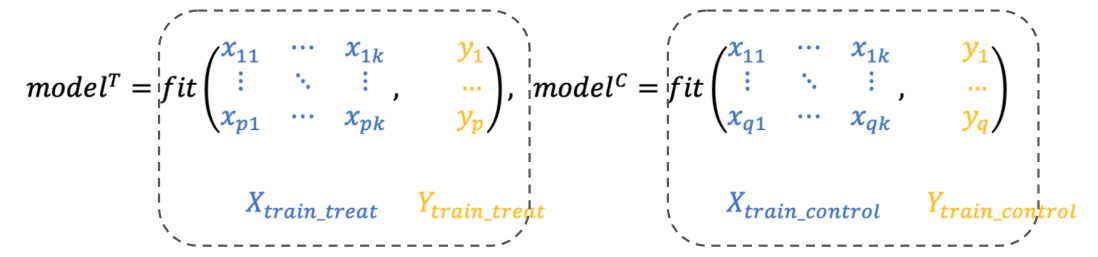

In [22]:
features = ['gender_encoded', 'age', 'first_issue_time', 'first_redeem_time', 'issue_redeem_delay']
target = 'target'

In [23]:
train_treatment = train[train['treatment_flg']==1]
val_treatment = val[val['treatment_flg']==1]

train_control = train[train['treatment_flg']==0]
val_control = val[val['treatment_flg']==0]

In [24]:
# Make sure we train two separate models: m0 and m1

m0 = CatBoostClassifier(iterations=100,
                        depth=4,
                        learning_rate=0.1,
                        random_seed=89,
                        eval_metric='Logloss',
                        verbose=10
                        )

m1 = CatBoostClassifier(iterations=100,
                        depth=4,
                        learning_rate=0.1,
                        random_seed=89,
                        eval_metric='Logloss',
                        verbose=10
                        )

In [25]:
print("Training m0 model on control set")

m0.fit(train_control[features], train_control[target],
       cat_features=[0],
       eval_set=(val_control[features], val_control[target]),
       early_stopping_rounds=5)

print()
print("Training m1 model on treatment set")

m1.fit(train_treatment[features], train_treatment[target],
       cat_features=[0],
       eval_set=(val_treatment[features], val_treatment[target]),
       early_stopping_rounds=5)

Training m0 model on control set
0:	learn: 0.6863275	test: 0.6865080	best: 0.6865080 (0)	total: 59.6ms	remaining: 5.9s
10:	learn: 0.6589849	test: 0.6601332	best: 0.6601332 (10)	total: 174ms	remaining: 1.41s
20:	learn: 0.6540390	test: 0.6558799	best: 0.6558799 (20)	total: 275ms	remaining: 1.03s
30:	learn: 0.6526778	test: 0.6546168	best: 0.6546168 (30)	total: 378ms	remaining: 841ms
40:	learn: 0.6522438	test: 0.6543224	best: 0.6543224 (40)	total: 471ms	remaining: 678ms
50:	learn: 0.6517039	test: 0.6539688	best: 0.6539688 (50)	total: 646ms	remaining: 621ms
60:	learn: 0.6512313	test: 0.6536100	best: 0.6536100 (60)	total: 870ms	remaining: 556ms
70:	learn: 0.6510288	test: 0.6534919	best: 0.6534919 (70)	total: 1.07s	remaining: 437ms
80:	learn: 0.6507642	test: 0.6533104	best: 0.6533104 (80)	total: 1.33s	remaining: 313ms
Stopped by overfitting detector  (5 iterations wait)

bestTest = 0.6533104313
bestIteration = 80

Shrink model to first 81 iterations.

Training m1 model on treatment set
0:	lea

**Step 2**. At this stage we model the unobserved world. Use the trained m0 (control) model to predict on the *treatment* dataset, then use the trained m1 (treatment) model to predict on the *control* dataset. After that, transform the target using the formula in the screenshot.

D1 = Y_treated - m0(X_treated) means that for a person in the treatment group we want to know what **would** have happened if they **hadn't got** treatment.

D0 = m1(X_control) - Y_control means that for a person in the control group we want to know what **would** have happened if they **had got** the treatment.  

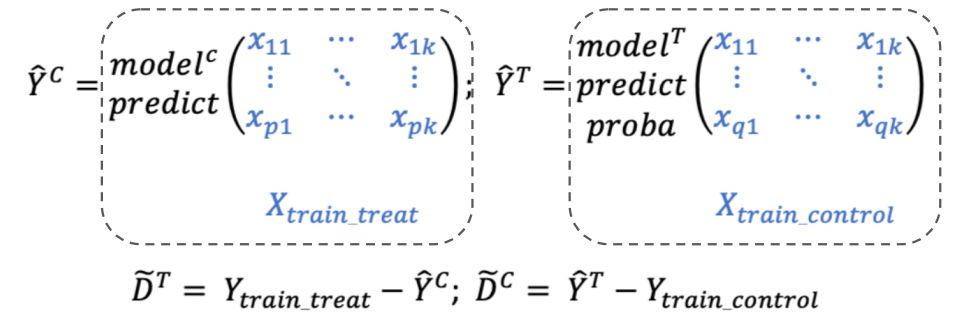

In [26]:
train_treatment['D_target'] = train_treatment[target] - m0.predict_proba(train_treatment[features])[:, 1]
val_treatment['D_target'] = val_treatment[target] - m0.predict_proba(val_treatment[features])[:, 1]

train_control['D_target'] = m1.predict_proba(train_control[features])[:, 1] - train_control[target]
val_control['D_target'] = m1.predict_proba(val_control[features])[:, 1] - val_control[target]

**Step 3**. Use the transformed targets to train second-level models.

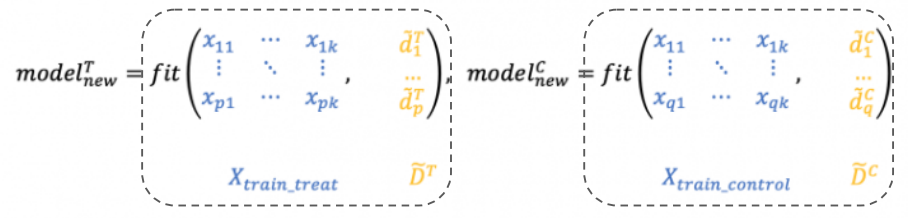

In [27]:
d_target = 'D_target'

In [28]:
# Make sure we train two separate models: mx0 and mx1

mx0 = CatBoostRegressor(iterations=100,
                        depth=4,
                        learning_rate=0.1,
                        random_seed=89,
                        eval_metric='RMSE',
                        verbose=10
                        )

mx1 = CatBoostRegressor(iterations=100,
                        depth=4,
                        learning_rate=0.1,
                        random_seed=89,
                        eval_metric='RMSE',
                        verbose=10
                        )

In [29]:
print("Training mx0 model on control set")

mx0.fit(train_control[features], train_control[d_target],
       cat_features=[0],
       eval_set=(val_control[features], val_control[d_target]),
       early_stopping_rounds=5)

print()
print("Training mx1 model on treatment set")

mx1.fit(train_treatment[features], train_treatment[d_target],
       cat_features=[0],
       eval_set=(val_treatment[features], val_treatment[d_target]),
       early_stopping_rounds=5)

Training mx0 model on control set
0:	learn: 0.4794004	test: 0.4804036	best: 0.4804036 (0)	total: 9.35ms	remaining: 926ms
10:	learn: 0.4788720	test: 0.4799396	best: 0.4799396 (10)	total: 84.2ms	remaining: 681ms
20:	learn: 0.4786784	test: 0.4798696	best: 0.4798662 (19)	total: 158ms	remaining: 594ms
30:	learn: 0.4784909	test: 0.4797940	best: 0.4797940 (30)	total: 228ms	remaining: 508ms
40:	learn: 0.4784239	test: 0.4797663	best: 0.4797663 (40)	total: 301ms	remaining: 434ms
50:	learn: 0.4783224	test: 0.4797396	best: 0.4797396 (50)	total: 374ms	remaining: 359ms
Stopped by overfitting detector  (5 iterations wait)

bestTest = 0.4797293751
bestIteration = 51

Shrink model to first 52 iterations.

Training mx1 model on treatment set
0:	learn: 0.4679428	test: 0.4674486	best: 0.4674486 (0)	total: 20.6ms	remaining: 2.04s
10:	learn: 0.4663900	test: 0.4659823	best: 0.4659823 (10)	total: 116ms	remaining: 939ms
20:	learn: 0.4660624	test: 0.4657769	best: 0.4657769 (20)	total: 246ms	remaining: 925ms
30:

**Step 4**. Use the trained 2nd-level models to predict on the test set while tweaking the g parameter.

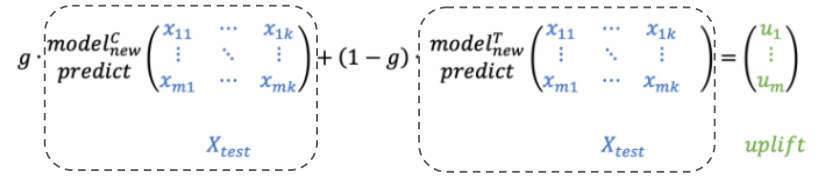

In [30]:
g_values = np.linspace(0.0, 1.0, num=11)
uplift_values = []
k = 0.1

In [31]:
# iterate through g values

for g in g_values:
  test['uplift'] = g*mx0.predict(test[features]) + (1-g)*mx1.predict(test[features])
  test_uplift_k = uplift_at_k(test['uplift'], test[target], test['treatment_flg'], k)
  uplift_values.append(test_uplift_k)

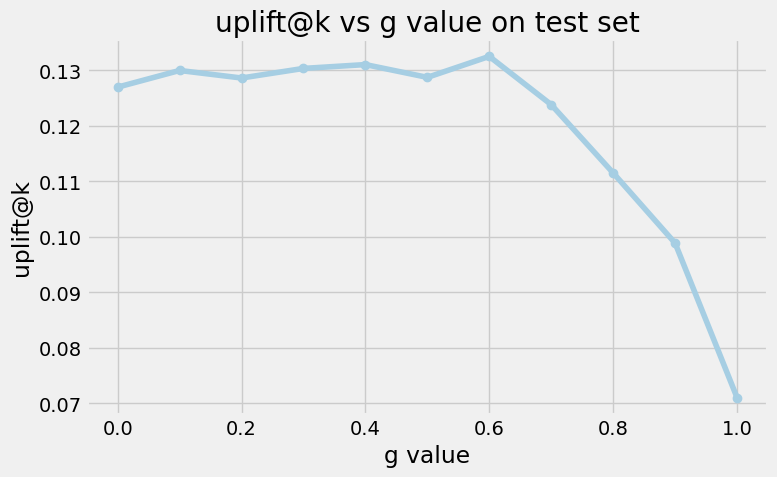

In [32]:
plt.figure(figsize=(8, 5))
plt.plot(g_values, uplift_values, marker='o', linestyle='-')
plt.xlabel('g value')
plt.ylabel('uplift@k')
plt.title('uplift@k vs g value on test set')
plt.grid(True)
plt.tight_layout()
plt.show()

Let's calculate uplift metrics on the train and test sets, using the best g parameter, and build the plots.

In [33]:
g = 0.6

In [34]:
train['uplift'] = g*mx0.predict(train[features]) + (1-g)*mx1.predict(train[features])
test['uplift'] = g*mx0.predict(test[features]) + (1-g)*mx1.predict(test[features])

In [35]:
train_uplift_k = uplift_at_k(train['uplift'], train[target], train['treatment_flg'], k)
test_uplift_k = uplift_at_k(test['uplift'], test[target], test['treatment_flg'], k)

In [36]:
# Create a dictionary to store the results

models_results = {
    'approach': [],
    f'train_uplift@{k*100}%': [],
    f'test_uplift@{k*100}%': []
}

In [37]:
models_results['approach'].append('X-learner')
models_results[f'train_uplift@{k*100}%'].append(train_uplift_k)
models_results[f'test_uplift@{k*100}%'].append(test_uplift_k)

In [38]:
pd.DataFrame(models_results)

,approach,train_uplift@10.0%,test_uplift@10.0%
0,X-learner,0.130742,0.132497


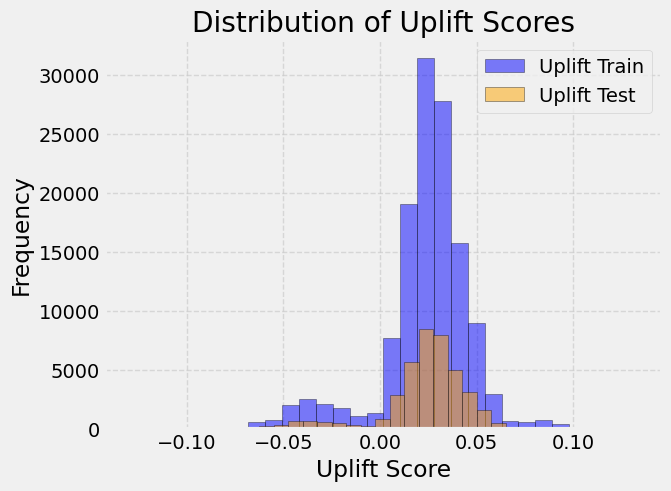

In [39]:
plot_uplift_distribution(train['uplift'], test['uplift'])

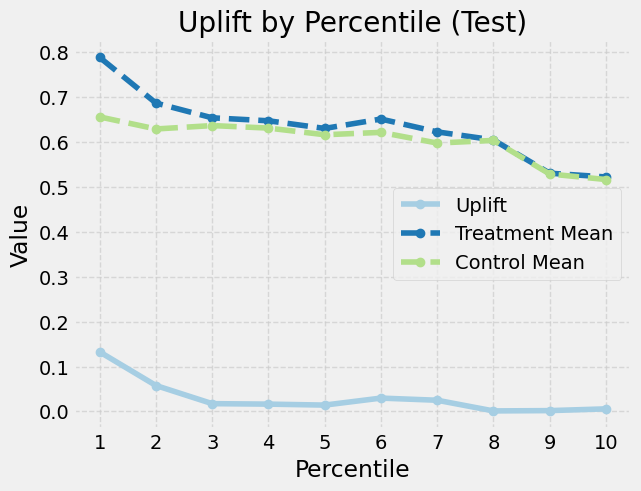

In [40]:
res = plot_uplift_by_percentile(test['uplift'], test[target], test['treatment_flg'], n_bins=10, title="Uplift by Percentile (Test)")

**Conclusion**. We can clearly see that our X-learner is picking out a small segment of the population with a noticeable uplift. Among the top 10% we're getting an uplift of ~0.13, which then drops down to about ~0.06 in the second percentile. Beyond the 30% of the population the effect is mostly negligible.

That means that we have a specific group of customers who truly benefit from treatment. If we only target the top 10% marked by our uplift model, we will be capturing most of the gain.

### Try additional metrics

In [41]:
y_true = test['target'].values
uplift = test['uplift'].values
treat = test['treatment_flg'].values

qini_auc = qini_auc_score(y_true=y_true, uplift=uplift, treatment=treat)
uplift_auc = uplift_auc_score(y_true=y_true, uplift=uplift, treatment=treat)

print(f"Qini AUC: {qini_auc:.4f}")
print(f"Uplift AUC: {uplift_auc:.4f}")

Qini AUC: 0.0183
Uplift AUC: 0.0262


The Qini AUC score tells us how much "benefit" we would get if we treated the top-ranked people first compared to random targeting.

The Uplift AUC score shows the average uplift we would see per person across all possible campaign sizes.

Let's also plot the curves.

In [42]:
plt.rcParams.update({
    'font.size': 10,
    'axes.titlesize': 12,
    'axes.labelsize': 11,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'legend.fontsize': 9
})

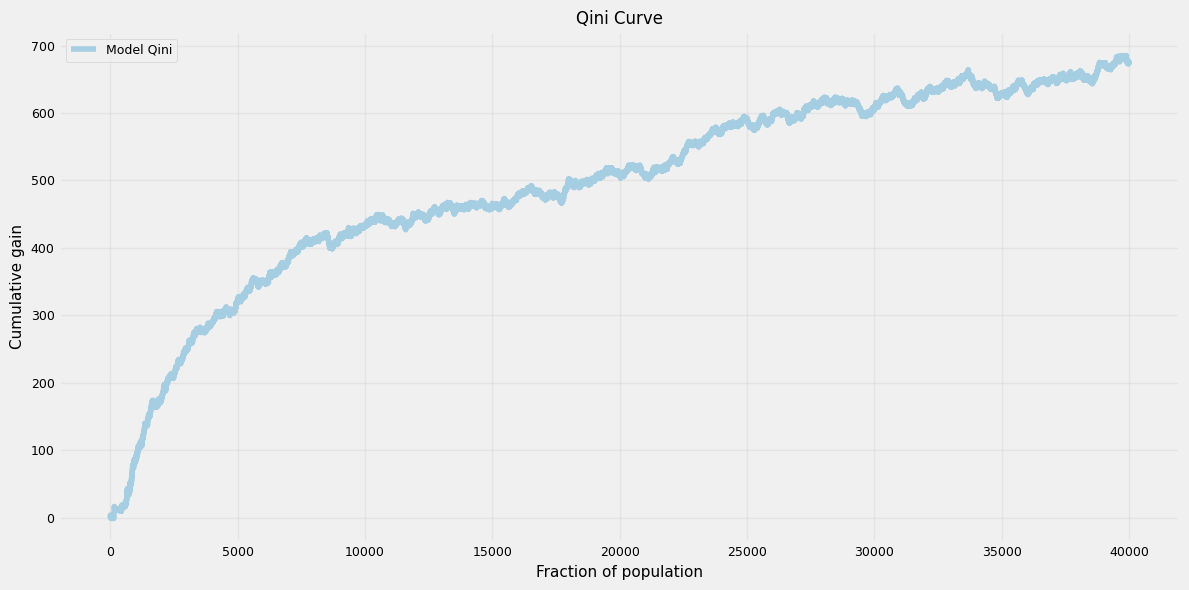

In [43]:
# Plot qini curve
fractions, qini_vals = qini_curve(y_true=y_true, uplift=uplift, treatment=treat)

plt.figure(figsize=(12,6))
plt.plot(fractions, qini_vals, label='Model Qini')
plt.xlabel("Fraction of population")
plt.ylabel("Cumulative gain")
plt.title("Qini Curve")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

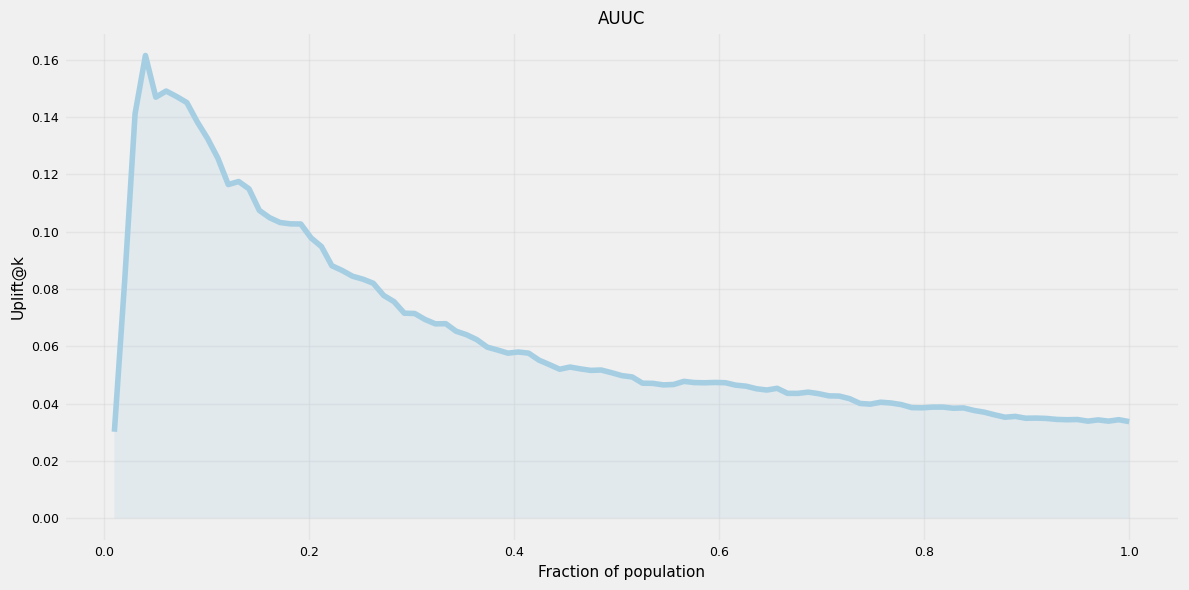

In [44]:
# Plot area under uplift curve
ks = np.linspace(0, 1, 100)
gains = [uplift_at_k(test['uplift'], test['target'], test['treatment_flg'], k) for k in ks]

plt.figure(figsize=(12,6))
plt.fill_between(ks, gains, alpha=0.2)
plt.plot(ks, gains, label='Uplift@k')
plt.xlabel("Fraction of population")
plt.ylabel("Uplift@k")
plt.title("AUUC")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Compare results

Now, let’s use the causalml and scikit-uplift libraries to train additional uplift models and compare their performance against the X-learner using the uplift@10% metric.

1. Target transformation approach

In [45]:
def transform_classes(y, treatment):
    return np.where(treatment == 1, y, 1 - y)

In [46]:
y_train_transformed = transform_classes(train[target], train['treatment_flg'])
y_val_transformed = transform_classes(val[target], val['treatment_flg'])
y_test_transformed = transform_classes(test[target], test['treatment_flg'])

In [47]:
catboost_model = CatBoostClassifier(iterations=100,
                                    depth=4,
                                    learning_rate=0.1,
                                    random_seed=89,
                                    eval_metric='Logloss',
                                    verbose=10
                                    )

catboost_model.fit(train[features], y_train_transformed,
                   cat_features=[0],
                   eval_set=(val[features], y_val_transformed),
                   early_stopping_rounds=5)

uplift_train_tt = catboost_model.predict_proba(train[features])[:, 1] - catboost_model.predict_proba(train[features])[:, 0]
uplift_test_tt = catboost_model.predict_proba(test[features])[:, 1] - catboost_model.predict_proba(test[features])[:, 0]

0:	learn: 0.6923820	test: 0.6923969	best: 0.6923969 (0)	total: 25.2ms	remaining: 2.5s
10:	learn: 0.6894662	test: 0.6895490	best: 0.6895490 (10)	total: 223ms	remaining: 1.8s
20:	learn: 0.6891368	test: 0.6892741	best: 0.6892741 (20)	total: 476ms	remaining: 1.79s
30:	learn: 0.6888940	test: 0.6890684	best: 0.6890671 (29)	total: 867ms	remaining: 1.93s
40:	learn: 0.6888020	test: 0.6890213	best: 0.6890213 (40)	total: 1.29s	remaining: 1.86s
50:	learn: 0.6886926	test: 0.6889326	best: 0.6889326 (50)	total: 1.66s	remaining: 1.6s
Stopped by overfitting detector  (5 iterations wait)

bestTest = 0.6889280135
bestIteration = 54

Shrink model to first 55 iterations.


In [48]:
train_uplift_k = uplift_at_k(uplift_train_tt, train[target], train['treatment_flg'], k)
test_uplift_k = uplift_at_k(uplift_test_tt, test[target], test['treatment_flg'], k)

models_results['approach'].append('ClassTransformation')
models_results[f'train_uplift@{k*100}%'].append(train_uplift_k)
models_results[f'test_uplift@{k*100}%'].append(test_uplift_k)

2. S-learner

In [49]:
s_learner = BaseSClassifier(
    learner=CatBoostClassifier(iterations=100,
                               depth=4,
                               learning_rate=0.1,
                               random_seed=89,
                               eval_metric='Logloss',
                               verbose=10
                               )
    )

s_learner.fit(X=train[features], treatment=train['treatment_flg'], y=train[target])

uplift_train_s = s_learner.predict(X=train[features].values.copy())
uplift_test_s = s_learner.predict(X=test[features].values.copy())

0:	learn: 0.6841781	total: 10.1ms	remaining: 1s
10:	learn: 0.6492474	total: 89.4ms	remaining: 724ms
20:	learn: 0.6426745	total: 174ms	remaining: 656ms
30:	learn: 0.6398251	total: 277ms	remaining: 616ms
40:	learn: 0.6382555	total: 362ms	remaining: 521ms
50:	learn: 0.6376177	total: 449ms	remaining: 432ms
60:	learn: 0.6369679	total: 535ms	remaining: 342ms
70:	learn: 0.6365614	total: 618ms	remaining: 253ms
80:	learn: 0.6363553	total: 700ms	remaining: 164ms
90:	learn: 0.6357636	total: 784ms	remaining: 77.5ms
99:	learn: 0.6355112	total: 864ms	remaining: 0us


In [50]:
train_uplift_k = uplift_at_k(uplift_train_s.flatten(), train[target], train['treatment_flg'], k)
test_uplift_k = uplift_at_k(uplift_test_s.flatten(), test[target], test['treatment_flg'], k)

models_results['approach'].append('S-Learner')
models_results[f'train_uplift@{k*100}%'].append(train_uplift_k)
models_results[f'test_uplift@{k*100}%'].append(test_uplift_k)

3. T-learner

In [51]:
t_learner = BaseTClassifier(
    learner=CatBoostClassifier(iterations=100,
                               depth=4,
                               learning_rate=0.1,
                               random_seed=89,
                               eval_metric='Logloss',
                               verbose=10
                               )
    )

t_learner.fit(X=train[features], treatment=train['treatment_flg'], y=train[target])

uplift_train_t = t_learner.predict(X=train[features].values.copy())
uplift_test_t = t_learner.predict(X=test[features].values.copy())

0:	learn: 0.6861340	total: 16.2ms	remaining: 1.6s
10:	learn: 0.6587640	total: 58ms	remaining: 470ms
20:	learn: 0.6542833	total: 102ms	remaining: 383ms
30:	learn: 0.6528669	total: 144ms	remaining: 321ms
40:	learn: 0.6520119	total: 188ms	remaining: 270ms
50:	learn: 0.6514789	total: 234ms	remaining: 225ms
60:	learn: 0.6507900	total: 276ms	remaining: 176ms
70:	learn: 0.6503324	total: 320ms	remaining: 131ms
80:	learn: 0.6501242	total: 364ms	remaining: 85.3ms
90:	learn: 0.6498658	total: 407ms	remaining: 40.2ms
99:	learn: 0.6494956	total: 448ms	remaining: 0us
0:	learn: 0.6822334	total: 4.96ms	remaining: 491ms
10:	learn: 0.6373474	total: 43.9ms	remaining: 355ms
20:	learn: 0.6286566	total: 87.6ms	remaining: 330ms
30:	learn: 0.6257545	total: 130ms	remaining: 290ms
40:	learn: 0.6242990	total: 173ms	remaining: 249ms
50:	learn: 0.6235165	total: 217ms	remaining: 208ms
60:	learn: 0.6227532	total: 263ms	remaining: 168ms
70:	learn: 0.6221721	total: 309ms	remaining: 126ms
80:	learn: 0.6218531	total: 351

In [52]:
train_uplift_k = uplift_at_k(uplift_train_t.flatten(), train[target], train['treatment_flg'], k)
test_uplift_k = uplift_at_k(uplift_test_t.flatten(), test[target], test['treatment_flg'], k)

models_results['approach'].append('Two-Model Approach (T-Learner)')
models_results[f'train_uplift@{k*100}%'].append(train_uplift_k)
models_results[f'test_uplift@{k*100}%'].append(test_uplift_k)

4. Two dependent models

In [53]:
tm_ctrl = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=100,
                                       depth=4,
                                       learning_rate=0.1,
                                       random_seed=89,
                                       eval_metric='Logloss',
                                       verbose=10
                                       ),
    estimator_ctrl=CatBoostClassifier(iterations=100,
                                      depth=4,
                                      learning_rate=0.1,
                                      random_seed=89,
                                      eval_metric='Logloss',
                                      verbose=10
                                      ),
    method='ddr_control'
    )

tm_ctrl = tm_ctrl.fit(
    train[features], train[target], train['treatment_flg'],
    estimator_trmnt_fit_params={
        'cat_features': [0],
        'early_stopping_rounds': 10,
        'verbose': 10
        },
    estimator_ctrl_fit_params={
        'cat_features': [0],
        'early_stopping_rounds': 10,
        'verbose': 10
        }
    )

uplift_train_tm_ctrl = tm_ctrl.predict(train[features])
uplift_test_tm_ctrl = tm_ctrl.predict(test[features])

0:	learn: 0.6863275	total: 10.7ms	remaining: 1.05s
10:	learn: 0.6589849	total: 99.2ms	remaining: 802ms
20:	learn: 0.6540390	total: 185ms	remaining: 695ms
30:	learn: 0.6526778	total: 278ms	remaining: 619ms
40:	learn: 0.6522438	total: 365ms	remaining: 525ms
50:	learn: 0.6517039	total: 450ms	remaining: 432ms
60:	learn: 0.6512313	total: 558ms	remaining: 357ms
70:	learn: 0.6510288	total: 650ms	remaining: 266ms
80:	learn: 0.6507642	total: 731ms	remaining: 171ms
90:	learn: 0.6506557	total: 819ms	remaining: 81ms
99:	learn: 0.6503596	total: 895ms	remaining: 0us
0:	learn: 0.6813847	total: 14.6ms	remaining: 1.45s
10:	learn: 0.6347269	total: 108ms	remaining: 877ms
20:	learn: 0.6265191	total: 204ms	remaining: 767ms
30:	learn: 0.6241000	total: 299ms	remaining: 666ms
40:	learn: 0.6232323	total: 390ms	remaining: 561ms
50:	learn: 0.6228261	total: 500ms	remaining: 481ms
60:	learn: 0.6225253	total: 596ms	remaining: 381ms
70:	learn: 0.6220425	total: 690ms	remaining: 282ms
80:	learn: 0.6217676	total: 786ms

In [54]:
train_uplift_k = uplift_at_k(uplift_train_tm_ctrl, train[target], train['treatment_flg'], k)
test_uplift_k = uplift_at_k(uplift_test_tm_ctrl, test[target], test['treatment_flg'], k)

models_results['approach'].append('Two-Model Approach (ddr_control)')
models_results[f'train_uplift@{k*100}%'].append(train_uplift_k)
models_results[f'test_uplift@{k*100}%'].append(test_uplift_k)

In [55]:
tm_trmnt = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=100,
                                       depth=4,
                                       learning_rate=0.1,
                                       random_seed=89,
                                       eval_metric='Logloss',
                                       verbose=10
                                       ),
    estimator_ctrl=CatBoostClassifier(iterations=100,
                                      depth=4,
                                      learning_rate=0.1,
                                      random_seed=89,
                                      eval_metric='Logloss',
                                      verbose=10
                                      ),
    method='ddr_treatment'
    )

tm_trmnt = tm_trmnt.fit(
    train[features], train[target], train['treatment_flg'],
    estimator_trmnt_fit_params={
        'cat_features': [0],
        'early_stopping_rounds': 10,
        'verbose': 10
        },
    estimator_ctrl_fit_params={
        'cat_features': [0],
        'early_stopping_rounds': 10,
        'verbose': 10
        }
    )

uplift_train_tm_trmnt = tm_trmnt.predict(train[features])
uplift_test_tm_trmnt = tm_trmnt.predict(test[features])

0:	learn: 0.6825650	total: 11.2ms	remaining: 1.11s
10:	learn: 0.6380021	total: 132ms	remaining: 1.07s
20:	learn: 0.6286673	total: 227ms	remaining: 856ms
30:	learn: 0.6259958	total: 317ms	remaining: 706ms
40:	learn: 0.6245730	total: 414ms	remaining: 596ms
50:	learn: 0.6239991	total: 504ms	remaining: 485ms
60:	learn: 0.6236396	total: 593ms	remaining: 379ms
70:	learn: 0.6229713	total: 685ms	remaining: 280ms
80:	learn: 0.6225198	total: 775ms	remaining: 182ms
90:	learn: 0.6221036	total: 867ms	remaining: 85.7ms
99:	learn: 0.6219118	total: 950ms	remaining: 0us
0:	learn: 0.6857008	total: 19.6ms	remaining: 1.94s
10:	learn: 0.6571733	total: 120ms	remaining: 968ms
20:	learn: 0.6519494	total: 213ms	remaining: 801ms
30:	learn: 0.6507508	total: 311ms	remaining: 693ms
40:	learn: 0.6501505	total: 407ms	remaining: 585ms
50:	learn: 0.6497382	total: 502ms	remaining: 482ms
60:	learn: 0.6494945	total: 596ms	remaining: 381ms
70:	learn: 0.6492978	total: 691ms	remaining: 282ms
80:	learn: 0.6491325	total: 779m

In [56]:
train_uplift_k = uplift_at_k(uplift_train_tm_trmnt, train[target], train['treatment_flg'], k)
test_uplift_k = uplift_at_k(uplift_test_tm_trmnt, test[target], test['treatment_flg'], k)

models_results['approach'].append('Two-Model Approach (ddr_treatment)')
models_results[f'train_uplift@{k*100}%'].append(train_uplift_k)
models_results[f'test_uplift@{k*100}%'].append(test_uplift_k)

In [57]:
pd.DataFrame(data=models_results).sort_values(f'test_uplift@{k*100}%', ascending=False)

,approach,train_uplift@10.0%,test_uplift@10.0%
0,X-learner,0.130742,0.132497
3,Two-Model Approach (T-Learner),0.149108,0.128133
1,ClassTransformation,0.124796,0.125890
4,Two-Model Approach (ddr_control),0.108902,0.113390
2,S-Learner,0.077616,0.093124
5,Two-Model Approach (ddr_treatment),0.086853,0.087161


Among our six approaches, the X-learner came out on top, demonstrating an uplift of about 13.3% in the top 10% of customers on the test set. The classic T-learner and the class transformation method aren't far behind, at roughly 12.8% and 12.6% uplift respectively. The approach based on two dependent models lags behind, and the simple S-learner sits at about 9.3%. In this case it's recommended to use either X-learner for maximum gain among the top group of customers or T-learner or class transformation, which give us almost as much uplift with less complexity.